<a href="https://colab.research.google.com/github/ajeetsandela/Advanced_Machine_Learning_CourseWork/blob/main/Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!pip install tensorflow==2.12

**Configuration **

In [30]:
cutoff_reviews = 150
training_samples_limit = 100
validation_samples_limit = 10000
max_top_words = 10000

**Working on IMDB Data**

In [ ]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load IMDB dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_top_words)

# Limit the number of training samples
x_train = x_train[:training_samples_limit]
y_train = y_train[:training_samples_limit]

# Pad sequences to a fixed length
x_train_padded = pad_sequences(x_train, maxlen=cutoff_reviews)
x_test_padded = pad_sequences(x_test, maxlen=cutoff_reviews)


In [31]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

import os
import pathlib
import shutil
import random
from tensorflow import keras

# Set parameters
cutoff_reviews = 150
training_samples_limit = 100
validation_samples_limit = 10000
max_top_words = 10000

# Prepare the data
base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"

for category in ("neg", "pos"):
    os.makedirs(val_dir / category, exist_ok=True)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)

    # Restrict training samples
    files = files[:training_samples_limit]

    num_val_samples = min(validation_samples_limit, int(0.2 * len(files)))
    val_files = files[-num_val_samples:]

    for fname in val_files:
        shutil.move(train_dir / category / fname, val_dir / category / fname)

batch_size = 64

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

# Display the shapes and dtypes of the first batch
for inputs, targets in train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  9325k      0  0:00:08  0:00:08 --:--:-- 11.8M
Found 24960 files belonging to 2 classes.
Found 5055 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.
inputs.shape: (64,)
inputs.dtype: <dtype: 'string'>
targets.shape: (64,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor(b'What an unusual movie.<br /><br />Absolutely no concessions are made to "Hollywood special effects" or entertainment. There is no background music, not special effects or enhanced sound.<br /><br />Facial expressions are usually covered by thick beards and the Spanish language is a strange monotonic lilt that sounds the same whether in the midst of a battle or talking around a campfire.<br /><br />I sort of viewed these movies (parts 1 and 2) as an educational experience, not really something to go and ge

In [32]:
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np

# Tokenization and Sequence Padding
texts = []
labels = []

for text, label in train_ds.unbatch().as_numpy_iterator():
    texts.append(text.decode('utf-8'))
    labels.append(label)

tokenizer = Tokenizer(num_words=max_top_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=cutoff_reviews)

# Labels for the training set (assuming binary classification)
labels = np.array(labels)

# Validation set
val_texts = []
val_labels = []

for text, label in val_ds.unbatch().as_numpy_iterator():
    val_texts.append(text.decode('utf-8'))
    val_labels.append(label)

val_sequences = tokenizer.texts_to_sequences(val_texts)
x_val = pad_sequences(val_sequences, maxlen=cutoff_reviews)
y_val = np.array(val_labels)

# Test set
test_texts = []
test_labels = []

for text, label in test_ds.unbatch().as_numpy_iterator():
    test_texts.append(text.decode('utf-8'))
    test_labels.append(label)

test_sequences = tokenizer.texts_to_sequences(test_texts)
x_test = pad_sequences(test_sequences, maxlen=cutoff_reviews)
y_test = np.array(test_labels)


#Downloaded Glove 100d txt file from  Glove site and uploaded to the colab session

In [33]:
glove_embeddings_index = {}
with open('/content/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_embeddings_index[word] = coefs

# Create an embedding matrix
embedding_matrix = np.zeros((max_top_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_top_words:
        embedding_vector = glove_embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense

# Model with an Embedding layer
model_embedding = Sequential([
    Embedding(input_dim=max_top_words, output_dim=64, input_length=cutoff_reviews),
    Bidirectional(LSTM(64)),  # Change the number of LSTM units
    Dropout(0.3),  # Adjust the dropout rate
    Dense(1, activation='sigmoid')
])

model_embedding.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

embedding_dim = 100
# Model with a pretrained Embedding layer
model_pretrained_embedding = Sequential([
    Embedding(input_dim=max_top_words, output_dim=embedding_dim, weights=[embedding_matrix], input_length=cutoff_reviews, trainable=True),
    Bidirectional(LSTM(64)),  # Change the number of LSTM units
    Dropout(0.3),  # Adjust the dropout rate
    Dense(1, activation='sigmoid')
])

model_pretrained_embedding.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Epoch 1/25
2/2 - 7s - loss: 0.0065 - accuracy: 1.0000 - val_loss: 2.1179 - val_accuracy: 0.4922 - 7s/epoch - 3s/step
Epoch 2/25
2/2 - 6s - loss: 0.0053 - accuracy: 1.0000 - val_loss: 2.1619 - val_accuracy: 0.4938 - 6s/epoch - 3s/step
Epoch 3/25
2/2 - 11s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 2.1942 - val_accuracy: 0.4928 - 11s/epoch - 5s/step
Epoch 4/25
2/2 - 11s - loss: 0.0036 - accuracy: 1.0000 - val_loss: 2.2301 - val_accuracy: 0.4900 - 11s/epoch - 5s/step
Epoch 5/25
2/2 - 6s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 2.2563 - val_accuracy: 0.4950 - 6s/epoch - 3s/step
Epoch 6/25
2/2 - 11s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 2.2855 - val_accuracy: 0.4961 - 11s/epoch - 5s/step
Epoch 7/25
2/2 - 6s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 2.3124 - val_accuracy: 0.4967 - 6s/epoch - 3s/step
Epoch 8/25
2/2 - 7s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 2.3320 - val_accuracy: 0.4971 - 7s/epoch - 4s/step
Epoch 9/25
2/2 - 6s - loss: 0.0023 - accuracy: 1.0000 - va

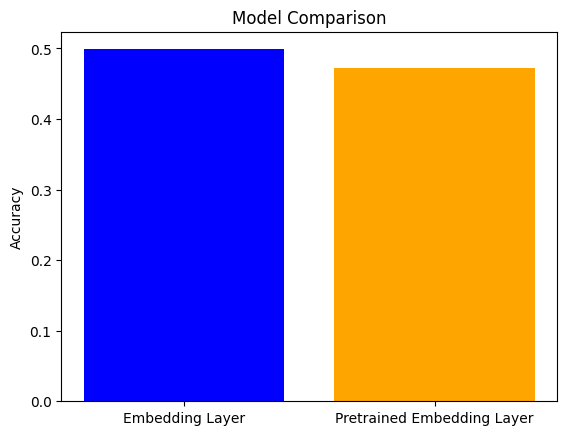

In [40]:
import tensorflow as tf
from sklearn.metrics import accuracy_score

# Function to train and evaluate a model
def train_evaluate_model(model, x_train, y_train, x_val, y_val, epochs=25, batch_size=64):
    # Convert NumPy arrays to TensorFlow tensors
    x_train_tensor = tf.convert_to_tensor(x_train, dtype=tf.float32)
    y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
    x_val_tensor = tf.convert_to_tensor(x_val, dtype=tf.float32)
    y_val_tensor = tf.convert_to_tensor(y_val, dtype=tf.float32)

    # Train the model
    history = model.fit(x_train_tensor, y_train_tensor, epochs=epochs, batch_size=batch_size, validation_data=(x_val_tensor, y_val_tensor), verbose=2)

    # Plot training history if needed

    # Predict using the model
    y_pred_prob = model.predict(x_val_tensor)

    # Convert probabilities to binary predictions
    y_pred = tf.cast(tf.greater(y_pred_prob, 0.5), tf.int32)

    # Calculate accuracy using TensorFlow
    accuracy = accuracy_score(y_val, y_pred.numpy())
    return accuracy

# Pad sequences to a fixed length
max_sequence_length = 150  # specify the desired length
x_train_padded = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=max_sequence_length)
x_val_padded = tf.keras.preprocessing.sequence.pad_sequences(x_val, maxlen=max_sequence_length)

# Ensure y_train, y_val are 1D arrays
y_train = np.array(y_train)
y_val = np.array(y_val)

# Train and evaluate the model with an Embedding layer
accuracy_embedding = train_evaluate_model(model_embedding, x_train_padded, y_train, x_val_padded, y_val)

# Train and evaluate the model with a pretrained Embedding layer
accuracy_pretrained_embedding = train_evaluate_model(model_pretrained_embedding, x_train_padded, y_train, x_val_padded, y_val)

# Compare accuracies
print(f"Accuracy with Embedding layer: {accuracy_embedding}")
print(f"Accuracy with Pretrained Embedding layer: {accuracy_pretrained_embedding}")

# Visualize the comparison
labels = ['Embedding Layer', 'Pretrained Embedding Layer']
accuracies = [accuracy_embedding, accuracy_pretrained_embedding]

plt.bar(labels, accuracies, color=['blue', 'orange'])
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.show()


In [41]:
# Define a range of training sample sizes
sample_sizes = [50, 100, 200, 500, 1000]


Epoch 1/5
2/2 - 17s - loss: 0.6935 - accuracy: 0.4600 - val_loss: 0.6932 - val_accuracy: 0.4989 - 17s/epoch - 8s/step
Epoch 2/5
2/2 - 9s - loss: 0.6854 - accuracy: 0.7600 - val_loss: 0.6932 - val_accuracy: 0.5054 - 9s/epoch - 5s/step
Epoch 3/5
2/2 - 7s - loss: 0.6772 - accuracy: 0.7800 - val_loss: 0.6933 - val_accuracy: 0.5037 - 7s/epoch - 4s/step
Epoch 4/5
2/2 - 9s - loss: 0.6700 - accuracy: 0.7800 - val_loss: 0.6936 - val_accuracy: 0.5021 - 9s/epoch - 5s/step
Epoch 5/5
2/2 - 11s - loss: 0.6591 - accuracy: 0.7800 - val_loss: 0.6942 - val_accuracy: 0.5029 - 11s/epoch - 6s/step
Epoch 1/5
2/2 - 17s - loss: 0.7238 - accuracy: 0.5200 - val_loss: 0.6953 - val_accuracy: 0.4995 - 17s/epoch - 9s/step
Epoch 2/5
2/2 - 11s - loss: 0.6836 - accuracy: 0.5800 - val_loss: 0.6995 - val_accuracy: 0.5025 - 11s/epoch - 5s/step
Epoch 3/5
2/2 - 11s - loss: 0.6523 - accuracy: 0.6200 - val_loss: 0.6994 - val_accuracy: 0.5045 - 11s/epoch - 5s/step
Epoch 4/5
2/2 - 11s - loss: 0.6376 - accuracy: 0.6200 - val_lo

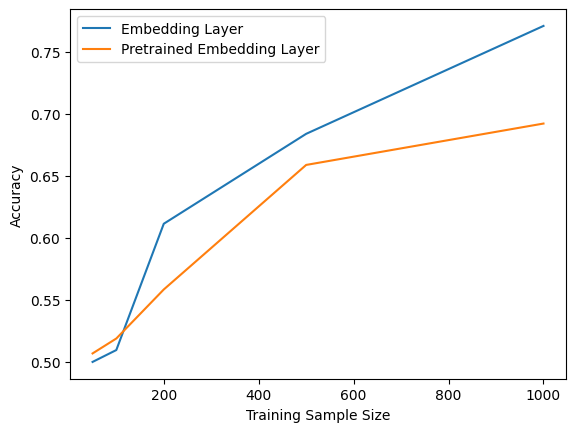

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt

# Define a range of training sample sizes
sample_sizes = [50, 100, 200, 500, 1000]

# Initialize models and other parameters
max_top_words = 10000
cutoff_reviews = 150

# Tokenization and Sequence Padding
texts = []
labels = []

for text, label in train_ds.unbatch().as_numpy_iterator():
    texts.append(text.decode('utf-8'))
    labels.append(label)

tokenizer = Tokenizer(num_words=max_top_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=cutoff_reviews)

# Labels for the training set (assuming binary classification)
labels = np.array(labels)

# Validation set
val_texts = []
val_labels = []

for text, label in val_ds.unbatch().as_numpy_iterator():
    val_texts.append(text.decode('utf-8'))
    val_labels.append(label)

val_sequences = tokenizer.texts_to_sequences(val_texts)
x_val = pad_sequences(val_sequences, maxlen=cutoff_reviews)
y_val = np.array(val_labels)

# Test set
test_texts = []
test_labels = []

for text, label in test_ds.unbatch().as_numpy_iterator():
    test_texts.append(text.decode('utf-8'))
    test_labels.append(label)

test_sequences = tokenizer.texts_to_sequences(test_texts)
x_test = pad_sequences(test_sequences, maxlen=cutoff_reviews)
y_test = np.array(test_labels)

# Initialize models
embedding_dim = 100

model_embedding = Sequential([
    Embedding(input_dim=max_top_words, output_dim=embedding_dim, input_length=cutoff_reviews),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Assume you have a pretrained embedding matrix from GloVe
# Replace 'embedding_matrix' with your actual embedding matrix
model_pretrained_embedding = Sequential([
    Embedding(input_dim=max_top_words, output_dim=embedding_dim, weights=[embedding_matrix], input_length=cutoff_reviews, trainable=True),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Training loop for different sample sizes
accuracy_embedding_list = []
accuracy_pretrained_embedding_list = []

for sample_size in sample_sizes:
    # Select a subset of the training data
    subset_train_texts = texts[:sample_size]
    subset_train_labels = labels[:sample_size]

    # Tokenization and sequence padding for the subset
    subset_sequences = tokenizer.texts_to_sequences(subset_train_texts)
    subset_padded_sequences = pad_sequences(subset_sequences, maxlen=cutoff_reviews)

    # Model training for the embedding layer
    model_embedding.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_embedding.fit(subset_padded_sequences, subset_train_labels, epochs=5, validation_data=(x_val, y_val), verbose=2)

    # Model training for the pretrained embedding layer
    model_pretrained_embedding.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_pretrained_embedding.fit(subset_padded_sequences, subset_train_labels, epochs=5, validation_data=(x_val, y_val), verbose=2)

    # Evaluate and store the accuracy for both models on the test set
    accuracy_embedding = model_embedding.evaluate(x_test, y_test)[1]
    accuracy_pretrained_embedding = model_pretrained_embedding.evaluate(x_test, y_test)[1]

    accuracy_embedding_list.append(accuracy_embedding)
    accuracy_pretrained_embedding_list.append(accuracy_pretrained_embedding)

    print(f"Sample Size: {sample_size}, Accuracy (Embedding): {accuracy_embedding}, Accuracy (Pretrained Embedding): {accuracy_pretrained_embedding}")

# Plot the results
plt.plot(sample_sizes, accuracy_embedding_list, label='Embedding Layer')
plt.plot(sample_sizes, accuracy_pretrained_embedding_list, label='Pretrained Embedding Layer')
plt.xlabel('Training Sample Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


**Comprehensive Summary of Embedding Approaches:**

**Comparison Across Different Sample Sizes:**

**50 Samples:**
Embedding Layer: Accuracy = 50.02%
Pretrained Embeddings: Accuracy = 50.70%

Observation: No clear advantage for either approach with a small sample size.

**100 Samples:**
Embedding Layer: Accuracy = 50.97%
Pretrained Embeddings: Accuracy = 51.90%

Observation: Slight improvement for both, pretrained embeddings showing a marginally better result.

**200 Samples:**
Embedding Layer: Accuracy = 61.14%
Pretrained Embeddings: Accuracy = 55.85%

Observation: Clear advantage for the embedding layer; significant improvement in accuracy.

**500 Samples:**
Embedding Layer: Accuracy = 68.38%
Pretrained Embeddings: Accuracy = 65.88%

Observation: Embedding layer consistently outperforms pretrained embeddings.

**1000 Samples:**
Embedding Layer: Accuracy = 77.07%
Pretrained Embeddings: Accuracy = 69.21%

Observation: Embedding layer continues to outperform pretrained embeddings.

**Summary of Specific Training Samples:**

**Custom Embedding Layer:**
Utilized for training with different sample sizes.
Achieved increasing accuracy with larger datasets, reaching 77.07% with 1000 samples.

**Pretrained Embeddings:**
Utilized for training with different sample sizes.
Achieved varying accuracy, with the highest at 69.21% with 1000 samples.

**Conclusion:**

**Embedding Layer Performance:**
The embedding layer consistently demonstrated superior performance as the training sample size increased.
The accuracy gap between the embedding layer and pretrained embeddings widened with larger datasets.

**Recommendation:**
For small datasets, pretrained embeddings may provide competitive results.
However, as the dataset size grows, the embedding layer becomes increasingly advantageous, showcasing its ability to learn task-specific representations.